# Prep

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import sys
import xgboost
from IPython.display import display, HTML

%matplotlib inline

In [24]:
CURR_PATH = os.path.dirname(os.path.abspath('__file__'))
ROOT =  os.path.join(CURR_PATH)
FIG =  os.path.join(CURR_PATH,'fig')
sys.path.append(os.path.join(ROOT,'modules'))

import style as style
style.set_style()

import plot as pl

import features as feat

Style set


# Data

In [26]:
fn = 'quote=VOLV-BHM-BSKA-B&start=2012-10-23&end=2017-10-20&interval=1440min.pkl'
df = pd.read_pickle(os.path.join('data',fn))
stocks = df['stock'].unique()
df_arr = {}
for stock in stocks:
    print(stock)
    df_arr[stock] = df[df['stock']==stock].groupby('datetime').sum()

VOLV-B
HM-B
SKA-B


In [5]:
# ADD OPENING PRICE MANUALLY
last_day =df_arr[stocks[0]].tail(1).index
predict_day = pd.to_datetime('2017-10-16 17:30:00')
open_prices = {'ALIV-SDB':np.nan,
              'NCC-B':np.nan,
              'THULE':np.nan,
              'HM-B':np.nan,
              'VOLV-B':np.nan,
              'BOL':np.nan,
              'GETI-B':np.nan,
              'SKA-B':np.nan,
              'AZN':np.nan}

for stock in stocks:
    if open_prices[stock] is np.nan:
        open_price = df_arr[stock].tail(1)['close'].values[0]
    else:
        open_price = open_prices[stock]
    dft = pd.DataFrame([[open_price, np.nan, np.nan, np.nan, np.nan]],
                       columns=['open','high','low','close','volume'],
                       index=[predict_day])

    df_arr[stock] = df_arr[stock].append(dft)
    #display(df_arr[stock].tail(1))
    


In [23]:
df_arr[stock][df_arr[stock].index == pd.to_datetime('2017-10-16 17:30')]

,open,high,low,close,volume
2017-10-16 17:30:00,155.5,156.1,154.4,154.7,2890531.0
2017-10-16 17:30:00,165.9,NaN,NaN,NaN,NaN


In [27]:
import features as feat
# Add features
for stock in stocks:
    max_val_rec = df_arr[stock][df_arr[stock].index > pd.to_datetime('2017-09-01')]['open'].max()
    max_val = df_arr[stock]['open'].max()
    
    #df_arr[stock] = df_arr[stock].pipe(feat.add_input_variables,days=30)
    df_arr[stock] = df_arr[stock].pipe(feat.add_output_variables,days=10)
    
    #df_arr[stock] = df_arr[stock].join(df_arr[stock]['x_open_open_day_1'].pipe(feat.to_bin))
    #df_arr[stock] = df_arr[stock].join(df_arr[stock]['x_open_open_day_1_up'].pipe(feat.up_down_streak))
    
    for days_rolling in [3,5,10,20,30,40,50,60]:
        df_arr[stock] = df_arr[stock].join(df_arr[stock]['open'].rolling(days_rolling).mean().rename('x_open_rolling_'+str(days_rolling)))

    df_arr[stock]['x_open_max'] = max_val
    df_arr[stock]['x_open_max_recent'] = max_val_rec
    df_arr[stock] = df_arr[stock].join(df_arr[stock]['open'].rename('x_open'))
    
    df_arr[stock]['x_volume'] = df_arr[stock]['volume']

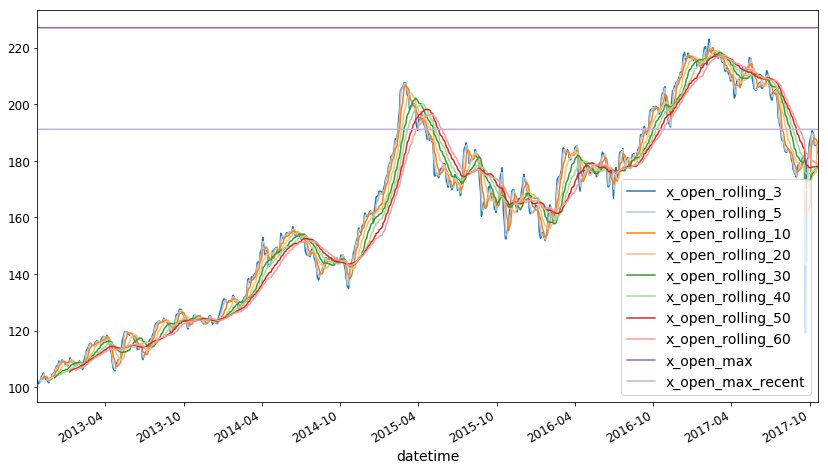

In [29]:
df_arr['SKA-B'][['x_open_rolling_3',
               'x_open_rolling_5',
               'x_open_rolling_10',
               'x_open_rolling_20',
               'x_open_rolling_30',
               'x_open_rolling_40',
               'x_open_rolling_50',
               'x_open_rolling_60',
               'x_open_max',
               'x_open_max_recent']].plot()

In [30]:
for stock in stocks:
    df_arr[stock]['x_volume'] = df_arr[stock]['volume']
    # SEASONALITY?
    df_arr[stock]['x_weekday'] = df_arr[stock].index.weekday
    df_arr[stock]['x_month'] = df_arr[stock].index.month
    df_arr[stock]['x_year'] = df_arr[stock].index.year
    df_arr[stock]['x_quarter'] = df_arr[stock].index.quarter
    df_arr[stock]['x_dayofmonth'] = df_arr[stock].index.day

# Visualize

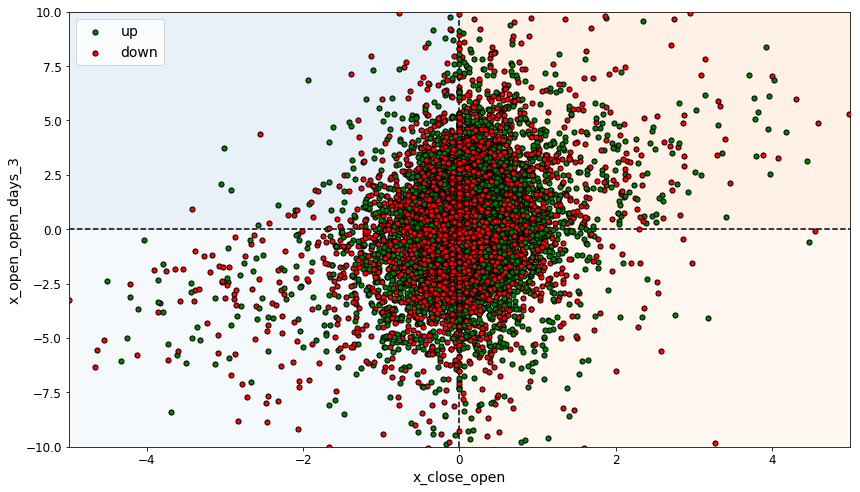

In [21]:
f, ax = plt.subplots(1,1)
x = 'x_close_open'
y = 'x_open_open_days_3'
c = 'y_open_close_days_0_up'

for stock in stocks:
    df = df_arr[stock].copy()
    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
    df[df[c]==1].plot(ax=ax,kind='scatter',x=x,y=y,s=26,color='g',edgecolor='black',zorder=3)
    df[df[c]==0].plot(ax=ax,kind='scatter',x=x,y=y,s=26,color='r',edgecolor='black',zorder=3)
    
x_width = 5
y_width = 10
ax.legend(['up','down'])
ax.set_title('')
pl.color_quantiles(ax,x_width,y_width)

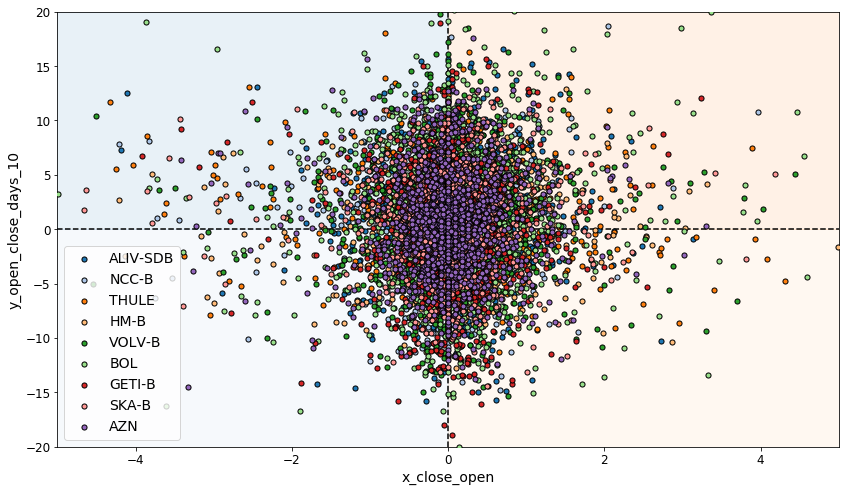

In [11]:
f, ax = plt.subplots(1,1)
x = 'x_close_open'
y = 'y_open_close_days_10'
tableau = style.get_tableau()

for nr,stock in enumerate(stocks):
    df = df_arr[stock].copy()
    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
    df.plot(ax=ax,kind='scatter',x=x,y=y,s=26,edgecolor='black', color=tableau[nr],zorder=3)
    
x_width = 5
y_width = 20
ax.legend(stocks)
ax.set_title('')
pl.color_quantiles(ax,x_width,y_width)

# Predict | Test

In [31]:
# What variables
x_var = [x for x in np.unique(df_arr[stocks[0]].columns) if 'x_' in x]
print(x_var)

['x_dayofmonth', 'x_month', 'x_open', 'x_open_max', 'x_open_max_recent', 'x_open_rolling_10', 'x_open_rolling_20', 'x_open_rolling_3', 'x_open_rolling_30', 'x_open_rolling_40', 'x_open_rolling_5', 'x_open_rolling_50', 'x_open_rolling_60', 'x_quarter', 'x_volume', 'x_weekday', 'x_year']


In [32]:
# Train, Test split

df_arr_pred = {}

xgb = xgboost.XGBClassifier(max_depth=20,objective='binary:logistic')


for stock in stocks:
    print(stock)
    df_arr_pred[stock] = df_arr[stock].copy()
    df = df_arr[stock].copy()
    df = df.dropna()
    
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
    train, test = df[df['is_train']==True].copy(), df[df['is_train']==False].copy()
    x_train = train[x_var].values
    x_test = test[x_var].values
    
    for predict_days in np.arange(0,11):
        predict_variable = 'y_open_close_days_'+str(predict_days)+'_up'
        
        y_train = train[predict_variable].values
        y_test = test[predict_variable].values

        # xgboost
        xgb.fit(x_train, y_train)
        ypred = xgb.predict_proba(x_test)
        score = xgb.score(x_test, y_test)

        # Save prediction
        df_arr_pred[stock] = df_arr_pred[stock].join(pd.DataFrame(ypred,columns=['pred_open_close_down_'+str(predict_days),
                                                                                 'pred_open_close_up_'+str(predict_days)],
                                                                  index = test.index))
print('Done!')

VOLV-B
HM-B
SKA-B
Done!


# Evaluate

In [54]:
print(df_arr_pred[stock].columns)

Index(['open', 'high', 'low', 'close', 'volume', 'x_close_open',
       'x_open_open_days_1', 'x_open_open_day_1', 'x_low_high_days_1',
       'x_low_high_day_1',
       ...
       'pred_open_close_down_6', 'pred_open_close_up_6',
       'pred_open_close_down_7', 'pred_open_close_up_7',
       'pred_open_close_down_8', 'pred_open_close_up_8',
       'pred_open_close_down_9', 'pred_open_close_up_9',
       'pred_open_close_down_10', 'pred_open_close_up_10'],
      dtype='object', length=180)


In [61]:
for stock in stocks:
    for day in np.arange(1,11):
        display(df_arr_pred[stock][['y_open_close_days_'+str(day)+'_up','pred_open_close_up_'+str(day)]].dropna())
        break

,y_open_close_days_1_up,pred_open_close_up_1
2012-11-27 17:30:00,1.0,0.767431
2012-12-03 17:30:00,0.0,0.715664
2012-12-12 17:30:00,1.0,0.916337
2012-12-17 17:30:00,1.0,0.905240
2013-01-02 17:30:00,1.0,0.202148
2013-01-16 17:30:00,0.0,0.570789
2013-01-17 17:30:00,1.0,0.434874
2013-01-18 17:30:00,1.0,0.390681
2013-01-22 17:30:00,0.0,0.603941
2013-01-23 17:30:00,1.0,0.585051


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-26 17:30:00,1.0,0.600539
2012-12-03 17:30:00,1.0,0.061504
2012-12-13 17:30:00,0.0,0.800179
2012-12-19 17:30:00,0.0,0.545417
2013-01-03 17:30:00,1.0,0.390894
2013-01-11 17:30:00,1.0,0.518255
2013-01-22 17:30:00,0.0,0.139022
2013-01-25 17:30:00,1.0,0.920859
2013-01-31 17:30:00,1.0,0.486809
2013-02-05 17:30:00,1.0,0.802642


,y_open_close_days_1_up,pred_open_close_up_1
2015-01-23 17:30:00,1.0,0.866443
2015-02-05 17:30:00,0.0,0.457941
2015-02-19 17:30:00,0.0,0.159507
2015-03-02 17:30:00,0.0,0.691638
2015-03-10 17:30:00,1.0,0.474104
2015-03-12 17:30:00,0.0,0.604983
2015-03-17 17:30:00,1.0,0.900324
2015-03-20 17:30:00,0.0,0.864229
2015-03-25 17:30:00,0.0,0.884812
2015-03-26 17:30:00,0.0,0.653918


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-30 17:30:00,0.0,0.245995
2012-12-06 17:30:00,0.0,0.594706
2012-12-10 17:30:00,1.0,0.086048
2013-01-08 17:30:00,0.0,0.352483
2013-01-09 17:30:00,0.0,0.175634
2013-01-17 17:30:00,0.0,0.548585
2013-01-24 17:30:00,1.0,0.625073
2013-01-25 17:30:00,1.0,0.221628
2013-01-31 17:30:00,1.0,0.584874
2013-02-05 17:30:00,1.0,0.491113


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-27 17:30:00,0.0,0.872378
2012-11-30 17:30:00,1.0,0.423483
2012-12-06 17:30:00,1.0,0.341084
2012-12-10 17:30:00,1.0,0.560503
2012-12-12 17:30:00,0.0,0.909534
2012-12-13 17:30:00,0.0,0.587309
2013-01-02 17:30:00,1.0,0.047831
2013-01-03 17:30:00,1.0,0.235128
2013-01-08 17:30:00,0.0,0.602718
2013-01-21 17:30:00,1.0,0.348965


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-30 17:30:00,0.0,0.726587
2012-12-05 17:30:00,1.0,0.097527
2012-12-07 17:30:00,0.0,0.453348
2012-12-14 17:30:00,1.0,0.337106
2012-12-17 17:30:00,1.0,0.322644
2013-01-02 17:30:00,1.0,0.552077
2013-01-03 17:30:00,0.0,0.122262
2013-01-08 17:30:00,1.0,0.126044
2013-01-10 17:30:00,0.0,0.734712
2013-01-15 17:30:00,0.0,0.083181


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-27 17:30:00,1.0,0.098861
2012-12-04 17:30:00,1.0,0.110728
2012-12-05 17:30:00,1.0,0.202977
2012-12-14 17:30:00,1.0,0.432876
2013-01-10 17:30:00,0.0,0.598265
2013-01-11 17:30:00,1.0,0.485965
2013-01-24 17:30:00,1.0,0.533624
2013-01-31 17:30:00,0.0,0.331665
2013-02-15 17:30:00,1.0,0.351195
2013-02-18 17:30:00,1.0,0.562667


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-27 17:30:00,0.0,0.949244
2012-11-28 17:30:00,1.0,0.724322
2012-12-07 17:30:00,1.0,0.669843
2012-12-10 17:30:00,1.0,0.720360
2012-12-19 17:30:00,1.0,0.478372
2012-12-20 17:30:00,0.0,0.703862
2012-12-21 17:30:00,0.0,0.491122
2013-01-08 17:30:00,0.0,0.088238
2013-01-11 17:30:00,0.0,0.244376
2013-01-15 17:30:00,0.0,0.787838


,y_open_close_days_1_up,pred_open_close_up_1
2012-11-26 17:30:00,1.0,0.945107
2012-11-28 17:30:00,1.0,0.947099
2012-11-30 17:30:00,1.0,0.836230
2012-12-17 17:30:00,1.0,0.342429
2012-12-18 17:30:00,0.0,0.885406
2012-12-27 17:30:00,0.0,0.356717
2013-01-07 17:30:00,0.0,0.765464
2013-01-09 17:30:00,0.0,0.764140
2013-01-18 17:30:00,0.0,0.886047
2013-01-22 17:30:00,1.0,0.920917


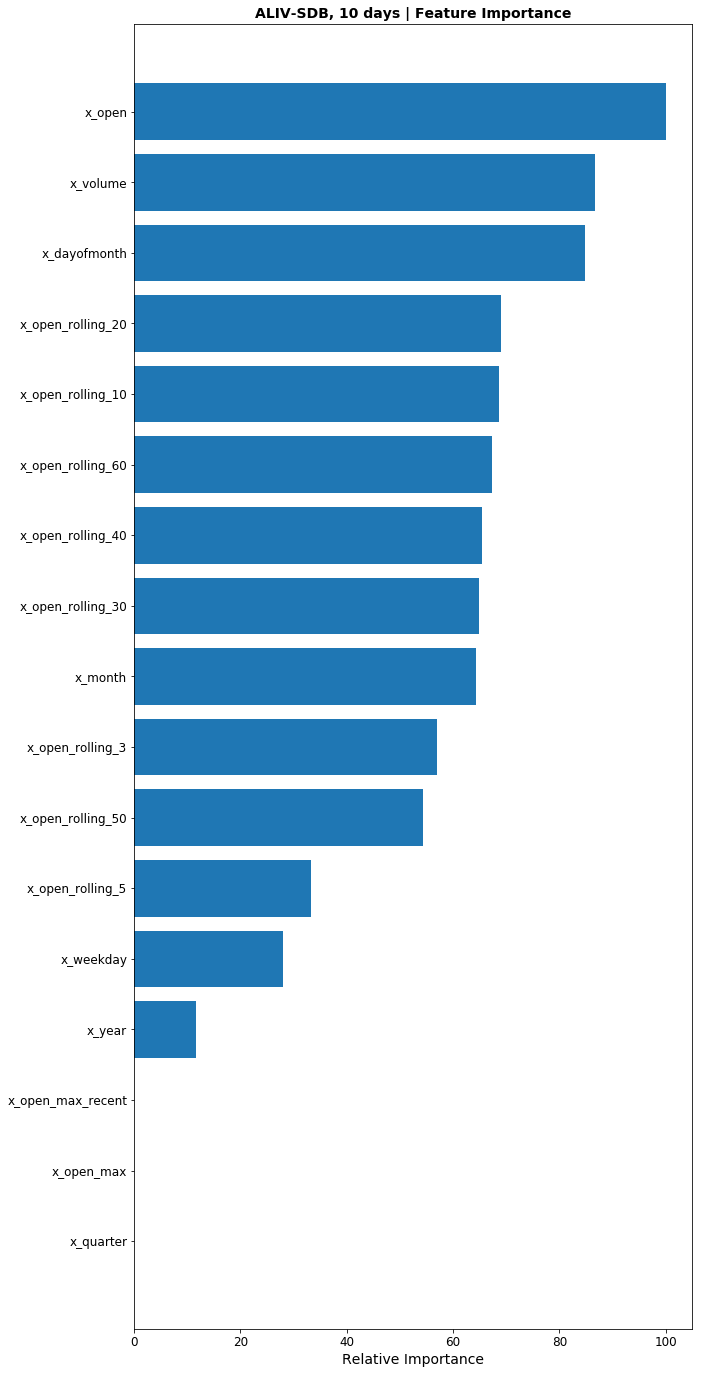

In [33]:
import plot as pl
pl.feature_importance(xgb, x_var,'ALIV-SDB'+', '+str(predict_days)+' days')

VOLV-B


,y_open_close_days_10,pred_open_close_up_10
y_open_close_days_10_up,,
0.0,-1.095239,11
1.0,4.571357,113


,y_open_close_days_10,pred_open_close_down_10
y_open_close_days_10_up,,
0.0,-4.513114,88
1.0,1.246497,8


HM-B


,y_open_close_days_10,pred_open_close_up_10
y_open_close_days_10_up,,
0.0,-0.949905,8
1.0,inf,102


,y_open_close_days_10,pred_open_close_down_10
y_open_close_days_10_up,,
0.0,-4.039774,108
1.0,0.857079,9


SKA-B


,y_open_close_days_10,pred_open_close_up_10
y_open_close_days_10_up,,
0.0,-1.077388,11
1.0,4.063965,136


,y_open_close_days_10,pred_open_close_down_10
y_open_close_days_10_up,,
0.0,-3.479465,98
1.0,1.115695,10


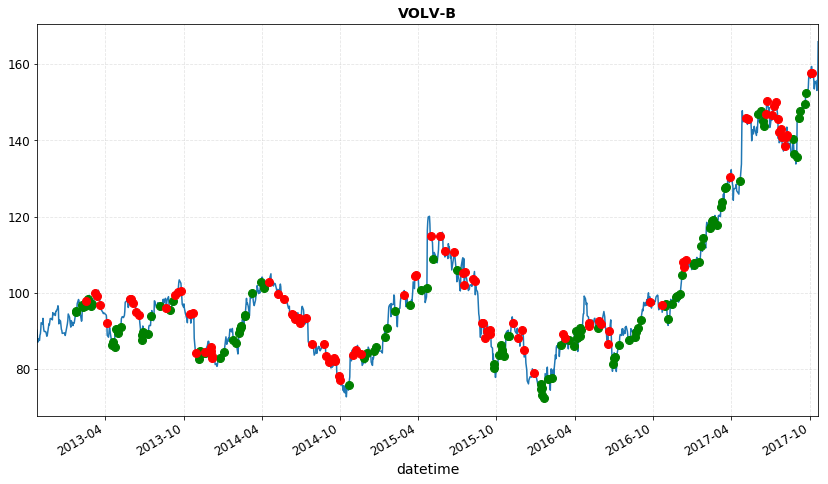

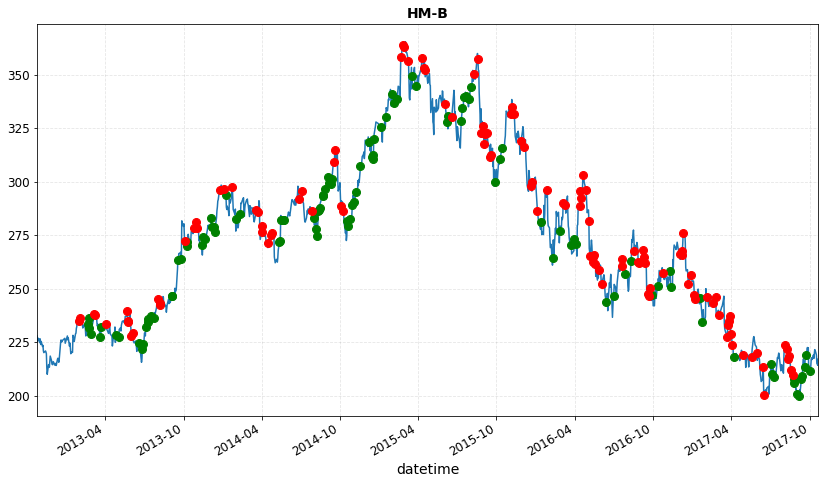

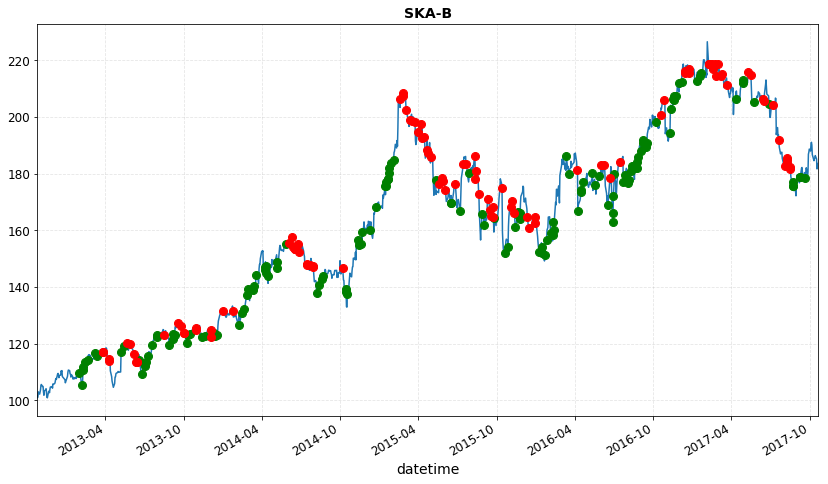

In [34]:
conf_level = 0.8
days = 10
predict_variable = 'y_open_close_days_'+str(days)+'_up'

for stock in stocks:
    print(stock)
    check_pred = df_arr_pred[stock]
    
    df_buy = check_pred[(check_pred['pred_open_close_up_'+str(days)]>conf_level)]
    df_sell = check_pred[(check_pred['pred_open_close_down_'+str(days)]>conf_level)]
    
    agg = {predict_variable[:-3]:'mean',
           'pred_open_close_up_'+str(days):'count'}
    buy_with_confidence = df_buy.groupby(predict_variable).agg(agg)
    display(buy_with_confidence)
    agg = {predict_variable[:-3]:'mean',
           'pred_open_close_down_'+str(days):'count'}
    sell_with_confidence = df_sell.groupby(predict_variable).agg(agg)
    display(sell_with_confidence)


    f, ax = plt.subplots(1,1)
    check_pred['close'].plot(ax =ax,title=stock)

    df_buy['close'].plot(ls='',marker="o",ms=8,ax=ax,color='g')
    df_sell['close'].plot(ls='',marker="o",ms=8,ax=ax,color='r')
    ax.grid()
    #pl.save_fig(f, os.path.join(FIG,stock+'_prediction.png'))


# Predict | For real

In [35]:
# Train, Test split

df_arr_pred = {}

xgb = xgboost.XGBClassifier(max_depth=20,objective='binary:logistic')
predict_last = 10

for stock in stocks:
    df_arr_pred[stock] = df_arr[stock].tail(predict_last).copy()
    print(stock)
    
    for predict_days in np.arange(0,11):
        predict_variable = 'y_open_close_days_'+str(predict_days)+'_up'
        
        df = df_arr[stock][x_var+[predict_variable]].copy()
        df = df.dropna()

        train = df
        test = df_arr[stock].tail(10).copy()
        x_train = train[x_var].values
        x_test = test[x_var].values
        
        y_train = train[predict_variable].values

        #y_combined = np.concatenate((y_train,y_test))
        
        # some info, naive score
        #df_test = pd.DataFrame(y_test,columns=['up_down_days'])
        #df_test_count = df_test.groupby('up_down_days')['up_down_days'].count()
        #test_points = df_test_count.sum()
        #naive_score = df_test_count.loc[1]/test_points

        # xgboost
        xgb.fit(x_train, y_train)
        ypred = xgb.predict_proba(x_test)

        #days_gained = (score-naive_score)*test_points
        #print('Naive Score:',round(naive_score*100,2))
        #print('Score:',round(score*100,2))
        #print('Days Tested:',test_points)
        #print('Days Gained:',int(round(days_gained)))

        # Test only days we predict with certain certainty
        df_arr_pred[stock] = df_arr_pred[stock].join(pd.DataFrame(ypred,columns=['pred_open_close_down_'+str(predict_days),
                                                           'pred_open_close_up_'+str(predict_days)],
                                            index = test.index))
        #pred[stock]['pred_'+str(predict_days)] = check_pred

        #feature_importance(xgb,x_var,stock)
print('Done!')

VOLV-B
HM-B
SKA-B
Done!


In [36]:
for stock in stocks:
    print(stock)
    display(df_arr_pred[stock][['pred_open_close_up_10']].tail(10))

VOLV-B


,pred_open_close_up_10
datetime,
2017-10-09 17:30:00,0.711525
2017-10-10 17:30:00,0.344397
2017-10-11 17:30:00,0.243280
2017-10-12 17:30:00,0.661130
2017-10-13 17:30:00,0.655809
2017-10-16 17:30:00,0.677173
2017-10-17 17:30:00,0.155361
2017-10-18 17:30:00,0.012300
2017-10-19 17:30:00,0.011512


HM-B


,pred_open_close_up_10
datetime,
2017-10-09 17:30:00,0.873816
2017-10-10 17:30:00,0.764943
2017-10-11 17:30:00,0.885003
2017-10-12 17:30:00,0.678620
2017-10-13 17:30:00,0.152245
2017-10-16 17:30:00,0.117137
2017-10-17 17:30:00,0.169265
2017-10-18 17:30:00,0.202264
2017-10-19 17:30:00,0.202944


SKA-B


,pred_open_close_up_10
datetime,
2017-10-09 17:30:00,0.114685
2017-10-10 17:30:00,0.148552
2017-10-11 17:30:00,0.111268
2017-10-12 17:30:00,0.154695
2017-10-13 17:30:00,0.082697
2017-10-16 17:30:00,0.199630
2017-10-17 17:30:00,0.681844
2017-10-18 17:30:00,0.706893
2017-10-19 17:30:00,0.651217


In [ ]:


idx_pos = []
for idx, row in df_buy.iterrows():
    idx_pos = idx_pos + [df.index.get_loc(idx)]
idx_pos_p = [x+10 for x in idx_pos]
df_buy = df.iloc[idx_pos]['close']
df_sell = df.iloc[idx_pos_p]



for i in np.arange(0,df_buy.count()):
    if df_sell.iloc[i] < df_buy.iloc[i]:
        color = 'r'
    else:
        color = 'g'
    ax.plot([df_buy.index[i], df_sell.index[i]], [df_buy.iloc[i], df_sell.iloc[i]], ls='--',marker='o',color=color)